In [25]:
from medAI.datasets import ExactNCT2013BModeImages, CohortSelectionOptions
import torch 
from torchvision import transforms as T
T.InterpolationMode.NEAREST

def transform(item): 
    bmode = item['bmode']
    needle_mask = item['needle_mask']
    grade = item['grade']

    bmode = torch.tensor(bmode).float()[None, ...]
    bmode = bmode.repeat(3, 1, 1)
    bmode = (bmode - bmode.min()) / (bmode.max() - bmode.min())
    bmode = T.Resize((1024, 1024), antialias=True)(bmode)
    bmode = bmode.flip(1)

    needle_mask = torch.tensor(needle_mask != 0).float()[None, ...]
    needle_mask = T.Resize((1024, 1024), interpolation=T.InterpolationMode.NEAREST, antialias=False)(needle_mask)
    needle_mask = needle_mask.flip(1)

    grade = torch.tensor(grade != 'Benign').long()

    return bmode, needle_mask, grade

cohort_selection_options = CohortSelectionOptions(
    min_involvement=40, benign_to_cancer_ratio=1
)
train_ds = ExactNCT2013BModeImages(split='train', transform=transform, cohort_selection_options=cohort_selection_options)
test_ds = ExactNCT2013BModeImages(split='test', transform=transform, cohort_selection_options=cohort_selection_options)

In [26]:
from segment_anything import build_sam_vit_b
from segment_anything import sam_model_registry
medsam_model = sam_model_registry["vit_b"](
    checkpoint="/h/pwilson/projects/medAI/projects/sam/logs/finetune_medsam/2023-11-06-17:41:34-benevolent-turaco/checkpoints/medsam-finetuned_nct_epoch=0_dice=0.88.pth"
)
medsam_model.eval()
medsam_model.cuda()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [27]:
from torch.utils.data import DataLoader
from einops import rearrange, repeat
from tqdm import tqdm

def collect_features(dataset):

    core_idx = []
    patch_feats = []
    patch_labels = [] 

    for i, batch in enumerate(tqdm(DataLoader(dataset, batch_size=8, num_workers=4))):
        bmode, needle_mask, grade = batch
        bmode = bmode.cuda()
        needle_mask = needle_mask.cuda()
        needle_mask = (needle_mask.unfold(-2, 16, 16).unfold(-2, 16, 16).mean((-1, -2)) > 0.5)
        needle_mask = needle_mask[:, 0, ...]

        grade = grade.cuda()
        
        with torch.no_grad():
            features = medsam_model.image_encoder(bmode)

        B, C, H, W = features.shape 

        batch_idx = torch.arange(B).cuda()[..., None, None].repeat([1, H, W]) + i * 4
        labels = grade[..., None, None].repeat([1, H, W])
        features = rearrange(features, 'b c h w -> (b h w) c')
        labels = rearrange(labels, 'b h w -> (b h w)')
        needle_mask = rearrange(needle_mask, 'b h w -> (b h w)')
        batch_idx = rearrange(batch_idx, 'b h w -> (b h w)')
        features = features[needle_mask] # N x C
        batch_idx = batch_idx[needle_mask] # N 
        labels = labels[needle_mask] # N

        core_idx.append(batch_idx.detach().cpu())
        patch_feats.append(features.detach().cpu())
        patch_labels.append(labels.detach().cpu())
        
    core_idx = torch.cat(core_idx, 0)
    patch_feats = torch.cat(patch_feats, 0)
    patch_labels = torch.cat(patch_labels, 0)

    return core_idx, patch_feats, patch_labels

train_core_idx, train_patch_feats, train_patch_labels = collect_features(train_ds)
test_core_idx, test_patch_feats, test_patch_labels = collect_features(test_ds)

  0%|                                                                                                                                      | 0/84 [00:00<?, ?it/s]

 24%|█████████████████████████████▊                                                                                               | 20/84 [00:21<01:10,  1.10s/it]


KeyboardInterrupt: 

In [ ]:
from sklearn.linear_model import LogisticRegression
X_train = train_patch_feats
y_train = train_patch_labels

clf = LogisticRegression(random_state=0, max_iter=10000).fit(X_train, y_train)

import numpy as np

y_hat_train = clf.predict_proba(X_train)
X_test = test_patch_feats
y_test = test_patch_labels
y_hat_test = clf.predict_proba(X_test)

from sklearn.metrics import roc_auc_score
print('train',  roc_auc_score(y_train, y_hat_train[:, 1]))
print('test',  roc_auc_score(y_test, y_hat_test[:, 1]))

y_test_core = [] 
y_hat_test_core = []
for i in test_core_idx.unique(): 
    y_test_core.append(y_test[test_core_idx == i][0])
    y_hat_test_core.append(y_hat_test[test_core_idx == i].mean(0))
y_test_core = np.stack(y_test_core)
y_hat_test_core = np.stack(y_hat_test_core)

print('test core',  roc_auc_score(y_test_core, y_hat_test_core[:, 1]))


train 0.6313703056017219
test 0.550567347114647
test core 0.603566958698373


In [ ]:
window_size = 5 * 1024 / (28), 5 * 1024 / (46.06)
window_size = (int(window_size[0]), int(window_size[1]))

In [ ]:
X_core = []
y_core = []
for i in train_core_idx.unique():
    X_core.append(X_train[train_core_idx == i].max(0)[0])
    y_core.append(y_train[train_core_idx == i][0])
X_core = torch.stack(X_core, 0)
y_core = torch.stack(y_core, 0)

X_core_test = []
y_core_test = []
for i in test_core_idx.unique():
    X_core_test.append(test_patch_feats[test_core_idx == i].max(0)[0])
    y_core_test.append(test_patch_labels[test_core_idx == i][0])
X_core_test = torch.stack(X_core_test, 0)
y_core_test = torch.stack(y_core_test, 0)

clf = LogisticRegression(random_state=0, max_iter=10000).fit(X_core, y_core)

print(roc_auc_score(y_core, clf.predict_proba(X_core)[:, 1]))
print(roc_auc_score(y_core_test, clf.predict_proba(X_core_test)[:, 1]))


0.7226527640787187
0.5309762202753442


In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1)
proj_train = tsne.fit_transform(X_core)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2090 samples in 0.001s...
[t-SNE] Computed neighbors for 2090 samples in 0.707s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2090
[t-SNE] Computed conditional probabilities for sample 2000 / 2090
[t-SNE] Computed conditional probabilities for sample 2090 / 2090
[t-SNE] Mean sigma: 0.178943
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.020805
[t-SNE] KL divergence after 1000 iterations: 1.842259


<Axes: >

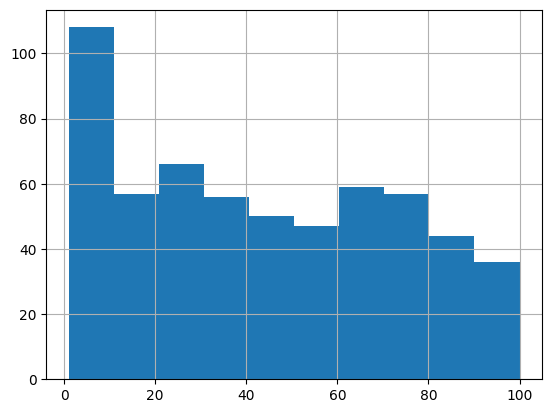

In [ ]:
train_ds.core_info.pct_cancer.hist()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
TSNE(n_components=2, verbose=1).fit_transform(patch_feats)

In [14]:
train_patch_feats.shape

torch.Size([248640, 256])

In [77]:
patch_feats.shape
patch_labels.shape
core_idx.shape

torch.Size([248640])

In [81]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
TSNE(n_components=2, verbose=1).fit_transform(patch_feats)

In [65]:
batch_idx

tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0')

In [ ]:
grade.shape

torch.Size([1, 1])

tensor(296, device='cuda:0')


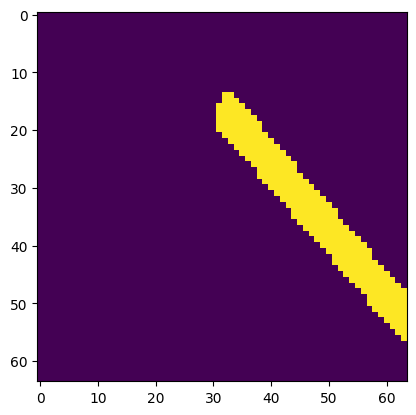

In [42]:
needle_mask = (needle_mask.unfold(-2, 16, 16).unfold(-2, 16, 16).mean((-1, -2)) > 0.5)
print(needle_mask.sum())
plt.imshow(needle_mask.cpu()[0,0])

In [44]:
256 * 6000 / 1e6

1.536

In [15]:
needle_mask[0,0]

TypeError: tuple indices must be integers or slices, not tuple

In [37]:
256 * 64 * 64 * 6000 / 1e9

6.291456

In [35]:
features.shape

torch.Size([1, 256, 64, 64])

In [ ]:
from torch.utils.data import DataLoader
for batch in DataLoader(train_ds, batch_size=1):
    bmode, needle_mask, grade = batch
    bmode = bmode.cuda()
    needle_mask = needle_mask.cuda()
    grade = grade.cuda()
    with torch.no_grad():
        pred = medsam_model(bmode)
    break



In [14]:
train_ds[0][2].shape

torch.Size([1])